**DATA 602 - Final Project**

Created and Presented by: Cole Dwiggins and Molly Moore

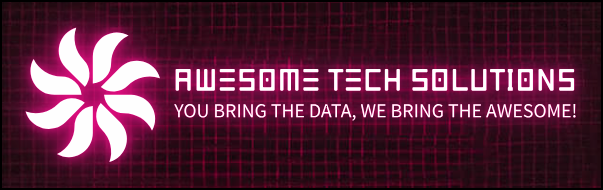

# **Introduction:**
**Problem:** Create a machine learning model to predict the outcome of whether or not an employee will leave the company.

**Type of Problem:** Classification

**Target Variable:** 'Left' (0/1 - 0 = stayed, 1 = left)

NOTE: Our data set does not contain the labels for whether or not an employee stayed/left.


\\

We were given a data set with the following features:
*   **Gender:** Male or Female (0/1)
*   **Distance:** Distance of commute to work (miles)
*   **YearsWorked:** # of years employee has worked at the company
*   **HireDate:** Date employee was hired
*   **PreviousSalary:** Employee's salary from the past year
*   **Salary:** Employee's current salary
*   **DepartmentCode:** # code for employee's assigned department

##Overview of Process##

*   Introduction
*   Initial data inspections / cleaning
*   Clustering (unsupervised learning)
*   Cluster Visualization (utilizing PCA for dimension reduction)
*   Analysis of underlying features within each assigned cluster class
*   Meeting with Subject Matter Expert
*   Assignment of Target Labels to Training Data
*   Development of Models for predicting Target Variable
*   Evaluation of Models (scoring)
*   Conclusion
*   Next Steps - Future Improvements


In [ ]:
#'Ask John - Subject Matter Expert'
import pandas as pd

class SME():

    def __init__(self):
        self.asked = 0
        self.df = self.get()

    def get(self):
        X_train = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final3/X_train.csv')
        y_train = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final3/y_train.csv')

        X_train['Left'] = y_train
        return X_train

    def ask(self, gender, distance, years_worked, hire_date, prev_salary, current_salary, dep_code):
        self.asked += 1
        #  print(self.asked)

        if self.asked > 500:
            raise Exception("Sorry, you have asked enough")

        result = self.df.query(f"Gender=={gender} and Distance=='{distance}' and YearsWorked == {years_worked} and HireDate == '{hire_date}' and PreviousSalary == '{prev_salary}' and Salary == '{current_salary}' and DepartmentCode == {dep_code}")

        left_value = int(result['Left'].values[0])

        return left_value

In [ ]:
#Initialize Subject Matter Expert
sme = SME()

In [ ]:
#Ex. Ask SME
sme.ask(0, '~20miles', 8, '2007-09-05',  '63K', '66K', 3)

1

In [ ]:
#Read in required data frames
X_train = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final3/X_train.csv')

X_test = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final3/X_test.csv')
y_test = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final3/y_test.csv')

#**Data Inspection and Cleaning**


In [ ]:
#Analyze data types, # of entries, and look for potential null values
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Gender          7500 non-null   int64 
 1   Distance        7490 non-null   object
 2   YearsWorked     7500 non-null   int64 
 3   HireDate        7500 non-null   object
 4   PreviousSalary  7500 non-null   object
 5   Salary          7500 non-null   object
 6   DepartmentCode  7500 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 410.3+ KB


> 'Distance' is the only feature with null values. We will add an **imputer** to the processing pipeline to handle these nulls.

> 'PreviousSalary and 'Salary' features should be reclassed from object type to int64.

> The decision was made not to use 'HireDate' for the prediction. We will leave this formatted as 'object' (string).

In [ ]:
#Analyze first few rows of data
X_train.head(10)

,Gender,Distance,YearsWorked,HireDate,PreviousSalary,Salary,DepartmentCode
0,0,~20miles,8,2007-09-05,63K,66K,3
1,0,>30miles,7,2011-10-16,60K,63K,3
2,0,~15miles,7,2011-05-18,59K,60K,3
3,1,<5mile,3,2000-06-30,60K,61K,2
4,1,~10miles,9,2010-04-28,56K,57K,7
5,1,~15miles,10,2008-01-10,60K,62K,1
6,0,~15miles,6,2007-06-10,62K,64K,2
7,0,~15miles,9,2000-02-29,63K,64K,2
8,1,~20miles,7,2007-05-24,59K,60K,6
9,0,~20miles,3,2013-07-16,62K,65K,7


> The 'PreviousSalary' and 'Salary' columns should be cleaned to show integer numbers in thousands. We will remove 'K' and cast as type 'int64'.

> The employee's 'Gender' should be converted to M/F instead of 0/1 for more accurate modeling. It will be used as a categorical variable.

> Engineer a new feature to capture the % increase/decrease in employee salary. ('SalaryDiff')

In [ ]:
#Reformat the Salary values to remove 1000 indicator (K), and set to data type 'int'
def cleanSalary(x):
    cleaned_x = x.replace('K', '')
    int_x = int(cleaned_x)
    return int_x

X_train['PreviousSalary'] = X_train['PreviousSalary'].apply(cleanSalary)
X_train['Salary'] = X_train['Salary'].apply(cleanSalary)

X_train.head(5)

#To confirm data type change
#X_train.info()

,Gender,Distance,YearsWorked,HireDate,PreviousSalary,Salary,DepartmentCode
0,0,~20miles,8,2007-09-05,63,66,3
1,0,>30miles,7,2011-10-16,60,63,3
2,0,~15miles,7,2011-05-18,59,60,3
3,1,<5mile,3,2000-06-30,60,61,2
4,1,~10miles,9,2010-04-28,56,57,7


In [ ]:
#Map 'Gender' values of (0 / 1) to (M / F) respectively
X_train['Gender'] = X_train['Gender'].map({0: 'M', 1: 'F'})
X_train.head(10)

,Gender,Distance,YearsWorked,HireDate,PreviousSalary,Salary,DepartmentCode
0,M,~20miles,8,2007-09-05,63,66,3
1,M,>30miles,7,2011-10-16,60,63,3
2,M,~15miles,7,2011-05-18,59,60,3
3,F,<5mile,3,2000-06-30,60,61,2
4,F,~10miles,9,2010-04-28,56,57,7
5,F,~15miles,10,2008-01-10,60,62,1
6,M,~15miles,6,2007-06-10,62,64,2
7,M,~15miles,9,2000-02-29,63,64,2
8,F,~20miles,7,2007-05-24,59,60,6
9,M,~20miles,3,2013-07-16,62,65,7


In [ ]:
#Engineer new feature for data set - captures % change in salary
X_train['SalaryDiff'] = round(((X_train['Salary'] - X_train['PreviousSalary']) / (X_train['PreviousSalary'])),2)
X_train.head(5)

#X_train.info() #SalaryDiff converts to float due to decimal

,Gender,Distance,YearsWorked,HireDate,PreviousSalary,Salary,DepartmentCode,SalaryDiff
0,M,~20miles,8,2007-09-05,63,66,3,0.05
1,M,>30miles,7,2011-10-16,60,63,3,0.05
2,M,~15miles,7,2011-05-18,59,60,3,0.02
3,F,<5mile,3,2000-06-30,60,61,2,0.02
4,F,~10miles,9,2010-04-28,56,57,7,0.02


In [ ]:
#Double-check data types
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          7500 non-null   object 
 1   Distance        7490 non-null   object 
 2   YearsWorked     7500 non-null   int64  
 3   HireDate        7500 non-null   object 
 4   PreviousSalary  7500 non-null   int64  
 5   Salary          7500 non-null   int64  
 6   DepartmentCode  7500 non-null   int64  
 7   SalaryDiff      7500 non-null   float64
dtypes: float64(1), int64(4), object(3)
memory usage: 468.9+ KB


Now that the 'Salary' formats have been cleaned, and a 'SalaryDiff' column has been added, we can move on to **Data Exploration**.

#**EDA** - Exploratory Data Analysis

In [ ]:
#Analyze make-up of data
X_train.describe()

,YearsWorked,PreviousSalary,Salary,DepartmentCode,SalaryDiff
count,7500.000000,7500.000000,7500.000000,7500.00000,7500.000000
mean,7.013067,59.517067,61.330933,3.99360,0.031159
std,1.865840,3.049199,3.228396,2.15822,0.013613
min,1.000000,48.000000,48.000000,1.00000,0.000000
25%,6.000000,58.000000,59.000000,2.00000,0.020000
50%,7.000000,60.000000,61.000000,3.00000,0.030000
75%,8.000000,62.000000,64.000000,6.00000,0.040000
max,14.000000,69.000000,72.000000,7.00000,0.090000


> We could analyze the data using boxplots and histograms to get a basic understanding of the structure - however, very little information will be gained regarding what characteristics constitute a resigned employee.

> We will implement some **unsupervised learning** to look for more subtle underlying patterns.

> Without the 'Stayed / Left' labels, we will move on to **clustering** the data and examine how characteristics differ between each cluster.

##Unsupervised Learning - Clustering##

> Kmeans will be used for clustering.

> Final goal is 2 clusters (Stayed / Left). We will work with more than 2 clusters and merge together as needed.

Before clustering should take place, the number of clusters should first be decided by analyzing how much variance is present in each set of clusters.

The appropriate number of clusters will be determined where the variance begins to stablilize.

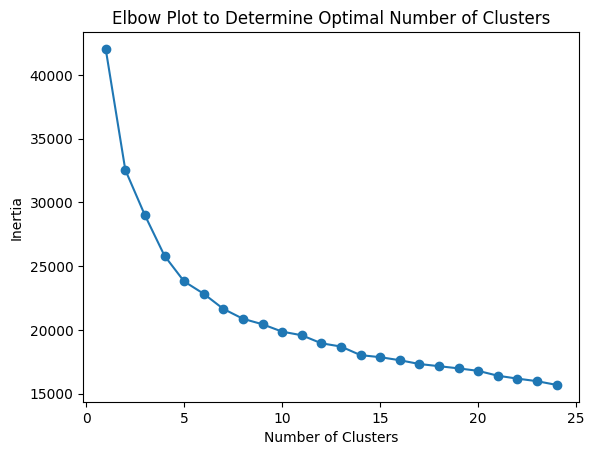

In [ ]:
#Build an elbow plot to determine the number of clusters to use

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

cat_vars = ['Gender', 'Distance', 'DepartmentCode']
num_vars = ['YearsWorked', 'PreviousSalary', 'Salary', 'SalaryDiff'] #'Tenure_CurrentSalary' #'Tenure_SalaryDiff'

cat_pipeline = Pipeline([
    ('impute_missing_cats', SimpleImputer(strategy='most_frequent')),('encoding', OneHotEncoder(drop='first', handle_unknown = 'ignore'))
])

num_pipeline = Pipeline([
    ('impute_missing', SimpleImputer(strategy='median')),('scaling', StandardScaler())
])

processing_pipeline = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_vars),
    ('cat_pipeline', cat_pipeline, cat_vars)
])

distortions = list()

for i in range(1, 25):
    km_modeling_pipeline = Pipeline([
        ('processing', processing_pipeline),
        ('k-means', KMeans(n_clusters=i, random_state=0, n_init='auto')),
    ])

    km = km_modeling_pipeline.fit(X_train)
    distortions.append(km.named_steps['k-means'].inertia_)

plt.plot(range(1, 25), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Plot to Determine Optimal Number of Clusters')
plt.show()

It is a little unclear where the point of inflection is. Let's take the second derivative of this graph.

In [ ]:
len(distortions)

24

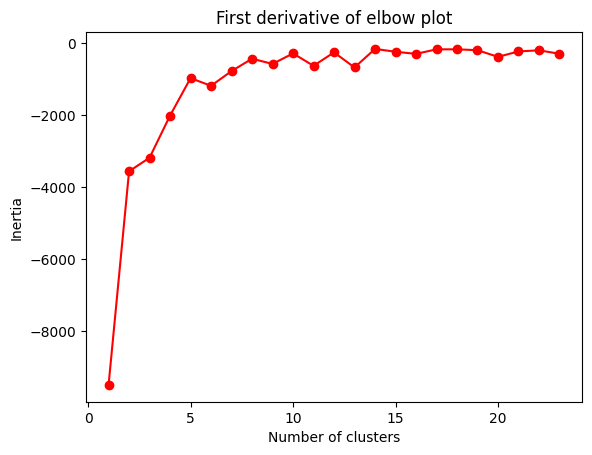

In [ ]:
#First Derivitave of elbow plot
distortions_dev_1 = list()
for i in range(1, 24):
  distortions_dev_1.append(distortions[i] - distortions[i-1])

plt.plot(range(1, 24), distortions_dev_1, 'ro-')
plt.title('First derivative of elbow plot')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
len(distortions_dev_1)

23

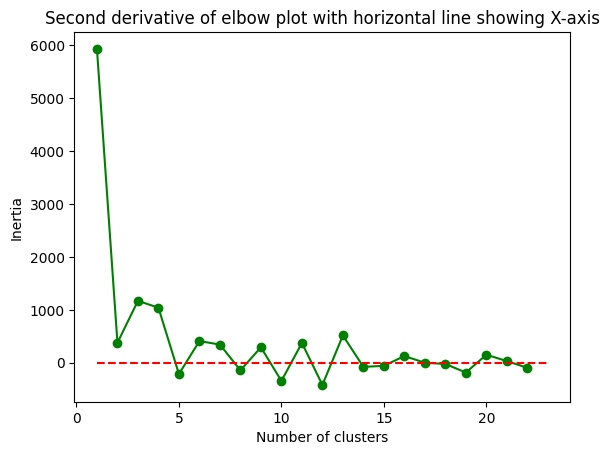

In [ ]:
#Second derivative of elbow plot
import numpy as np
distortions_dev_2 = list()
for i in range(1, 23):
  distortions_dev_2.append(distortions_dev_1[i] - distortions_dev_1[i-1])

plt.plot(range(1, 23), distortions_dev_2, 'go-')
plt.plot(range(1, 24), np.zeros(23), 'r--')
plt.title('Second derivative of elbow plot with horizontal line showing X-axis')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Based on this graph, the intertia begins to stablilize after **5 clusters**, so we will categorize the data into 5 clusters.

> **Note:** There may be a case to be made for **14 clusters** - the inertia is much more stable around the 0 line after 14. *(We will explore this further)*

#PCA - Dimension Reduction##

To ensure that the clustering did a proper job, principal component analysis (PCA) will be used to visualize the clustering.

Visualizations will be in the form of scatterplots.

In [ ]:
#Create a PCA pipeline
from sklearn.decomposition import PCA

#Kmeans with 5 clusters
km_modeling_pipeline = Pipeline([
    ('processing', processing_pipeline),
    ('k-means', KMeans(n_clusters=5, random_state=0, n_init='auto'))

])

#Initiate PCA with 2 components for 2-dimensional analysis
pca_modeling_pipeline = Pipeline([
    ('processing', processing_pipeline),
    ('pca', PCA(n_components=2))
])

#Set up transformed data frame (containing principal components) and k-Means clustering labels
X_train_cluster_predict = km_modeling_pipeline.fit(X_train)
X_train_cluster_predict = X_train_cluster_predict.predict(X_train)
new_X_train = pca_modeling_pipeline.fit_transform(X_train)

In [ ]:
#Contstruct the new dataframe and verify it was done correctly
new_X_train_df = pd.DataFrame(new_X_train)
new_X_train_df = pd.concat([new_X_train_df, pd.Series(X_train_cluster_predict)], axis=1)
new_X_train_df.columns = ['comp1', 'comp2', 'class']
new_X_train_df.head(5)

,comp1,comp2,class
0,-1.969118,1.247654,3
1,-0.640863,1.332564,3
2,0.508504,-0.789728,2
3,-0.008395,-1.168587,4
4,1.877967,-0.440515,2


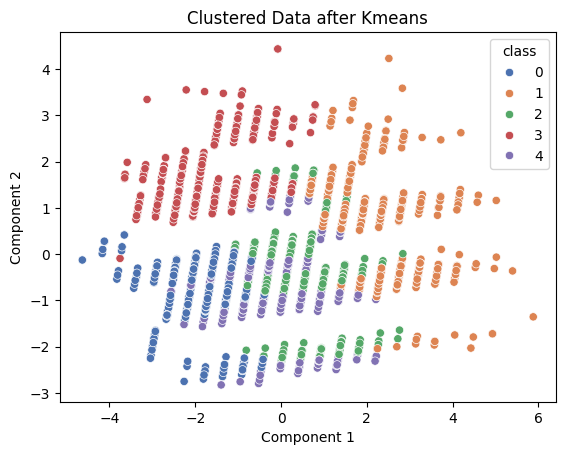

In [ ]:
#Plot the clustered data
import seaborn as sns

sns.scatterplot(x='comp1', y='comp2', hue='class', palette="deep", data=new_X_train_df)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Clustered Data after Kmeans')
plt.show()

> Clustering with 5 classes only performed modestly well. There are two fairly distinct classes - Class 1 and Class 3.

> The other 3 classes show a lot of overlap.

> Therefore, we will examine the data in three dimensions to see if there is any visible difference.

In [ ]:
#Initiate PCA with 3 components for 3-dimensional analysis
pca_modeling_pipeline = Pipeline([
    ('processing', processing_pipeline),
    ('pca', PCA(n_components=3))
])

#Set up transformed data frame (containing principal components) and k-Means clustering labels
X_train_cluster_predict = km_modeling_pipeline.fit(X_train)
X_train_cluster_predict = X_train_cluster_predict.predict(X_train)
new_X_train = pca_modeling_pipeline.fit_transform(X_train)

In [ ]:
#Contstruct the new dataframe and verify it was done correctly
new_X_train_df = pd.DataFrame(new_X_train)
new_X_train_df = pd.concat([new_X_train_df, pd.Series(X_train_cluster_predict)], axis=1)
new_X_train_df.columns = ['comp1', 'comp2', 'comp3', 'class']
new_X_train_df.head(5)

,comp1,comp2,comp3,class
0,-1.969118,1.247654,0.392147,3
1,-0.640863,1.332564,-0.197863,3
2,0.508504,-0.789728,0.097787,2
3,-0.008395,-1.168587,-1.993784,4
4,1.877967,-0.440515,1.094021,2


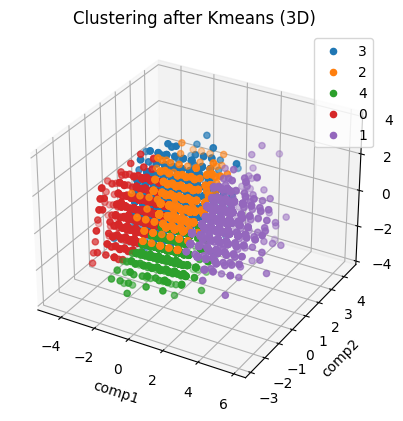

In [ ]:
#Plot the data in three dimensions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for c in new_X_train_df['class'].unique():
    ax.scatter(new_X_train_df.comp1[new_X_train_df['class'] == c],
               new_X_train_df.comp2[new_X_train_df['class'] == c],
               new_X_train_df.comp3[new_X_train_df['class'] == c],
               label=c)

ax.set_xlabel('comp1')
ax.set_ylabel('comp2')
ax.set_zlabel('comp3')

ax.legend()
plt.title('Clustering after Kmeans (3D)')
plt.show()


> With a 3D-view we can see the classes and how they overlap from a different angle.

> Clustering is moderately improved but there appears to still be some overlap between the groups.

> This could be due to having too many clusters present, thus it may be beneficial to merge the clusters later on.

##Question:##

**What if 14 clusters were used?**

> We were worried that 5 clusters may not offer the model enough distinction between classes.

> Based on the 2nd derivitave elbow plot, we are going to try 14 clusters to see if Kmeans can make clearer distinctions between smaller groups. Merging will occur later on.

In [ ]:
#Create a PCA pipeline
from sklearn.decomposition import PCA

#Kmeans with 14 clusters
km_modeling_pipeline = Pipeline([
    ('processing', processing_pipeline),
    ('k-means', KMeans(n_clusters=14, random_state=0, n_init='auto'))

])

pca_modeling_pipeline = Pipeline([
    ('processing', processing_pipeline),
    ('pca', PCA(n_components=2))
])

#Set up transformed data frame (containing principal components) and k-Means clustering labels
X_train_cluster_predict = km_modeling_pipeline.fit(X_train)
X_train_cluster_predict = X_train_cluster_predict.predict(X_train)
new_X_train = pca_modeling_pipeline.fit_transform(X_train)

In [ ]:
#Contstruct the new dataframe and verify it was done correctly
new_X_train_df = pd.DataFrame(new_X_train)
new_X_train_df = pd.concat([new_X_train_df, pd.Series(X_train_cluster_predict)], axis=1)
new_X_train_df.columns = ['comp1', 'comp2', 'class']
new_X_train_df.head(5)

,comp1,comp2,class
0,-1.969118,1.247654,3
1,-0.640863,1.332564,13
2,0.508504,-0.789728,10
3,-0.008395,-1.168587,5
4,1.877967,-0.440515,1


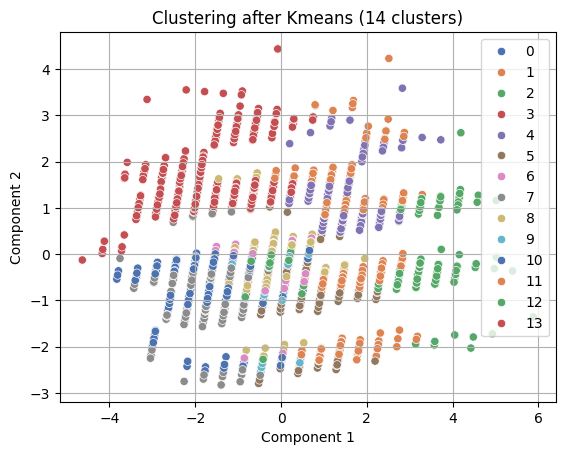

In [ ]:
#Plot the data
import seaborn as sns

sns.scatterplot(x='comp1', y='comp2', hue='class', palette="deep", data=new_X_train_df)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(True)
plt.title('Clustering after Kmeans (14 clusters)')
plt.show()

> This scatterplot shows a lot of overlapping classes - but there is still something to learn.

> We can see Class 3 is still very distinct. Additionally, Class 1 is also holding onto some of it's previous integrity, but part of it is now broken into Class 2 and Class 4.

> The grouping in the bottom left area has broken out into the most new classes. So we know this area is where the unsupervised learning is having the most trouble separating the data points.

In [ ]:
#Create the final pre-processing pipeline

#Kmeans with 14 clusters
km_modeling_pipeline = Pipeline([
    ('processing', processing_pipeline),
    ('k-means', KMeans(n_clusters=14, random_state=0, n_init='auto'))

])

X_train_cluster_predict = km_modeling_pipeline.fit(X_train)
X_train_cluster_predict = X_train_cluster_predict.predict(X_train)

In [ ]:
# Merge the cluster labels with the rest of the training data for further analysis
X_train_cluster_predict_series = pd.Series(X_train_cluster_predict)
new_X_train_df = pd.concat([X_train, X_train_cluster_predict_series], axis=1)
new_X_train_df = new_X_train_df.rename(columns={0: 'class'})
new_X_train_df.head(5)

,Gender,Distance,YearsWorked,HireDate,PreviousSalary,Salary,DepartmentCode,SalaryDiff,class
0,M,~20miles,8,2007-09-05,63,66,3,0.05,3
1,M,>30miles,7,2011-10-16,60,63,3,0.05,13
2,M,~15miles,7,2011-05-18,59,60,3,0.02,10
3,F,<5mile,3,2000-06-30,60,61,2,0.02,5
4,F,~10miles,9,2010-04-28,56,57,7,0.02,1


##Analysis - post clustering##

**What are the common characteristics among each class?**

In [ ]:
#Analyze make up of gender in each class
class_gender = new_X_train_df.groupby(['class', 'Gender']).Gender.count()
class_gender

class  Gender
0      F         196
       M         380
1      F         233
       M         385
2      F         326
       M         419
3      F         229
       M         311
4      F         256
       M         376
5      F         205
       M         308
6      F         168
       M         260
7      F         246
       M         303
8      F         191
       M         301
9      F         208
       M         299
10     F         271
       M         388
11     F         183
       M         276
12     F         107
       M         165
13     F         212
       M         298
Name: Gender, dtype: int64

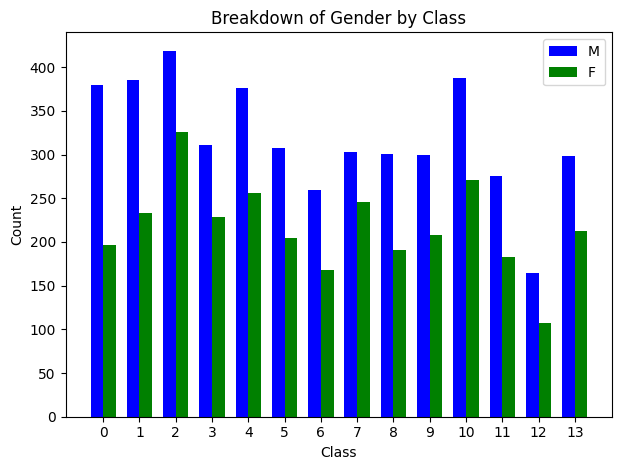

In [ ]:
#Plot gender distribution for each class
males = class_gender.loc[:,'M'].values
females = class_gender.loc[:, 'F'].values
classes = list(range(0, 14))

bar_width = 0.35

plt.bar([c - bar_width/2 for c in classes], males, bar_width, color='b', label='M', align='center')
plt.bar([c + bar_width/2 for c in classes], females, bar_width, color='g', label='F', align='center')

plt.title('Breakdown of Gender by Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.xticks(classes, classes)
plt.show()

> Fairly consistent gender distribution pattern between classes. Not very significant.

In [ ]:
#Plot distribution of 'Distance' for each class
class_distance = new_X_train_df.groupby(['class', 'Distance']).Distance.count()
class_distance

class  Distance
0      <5mile       68
       >30miles     60
       ~10miles    160
       ~15miles    183
       ~20miles    105
1      <5mile       58
       >30miles     56
       ~10miles    195
       ~15miles    191
       ~20miles    118
2      <5mile      170
       >30miles    177
       ~20miles    398
3      <5mile       50
       >30miles     55
       ~10miles    164
       ~15miles    148
       ~20miles    122
4      <5mile       71
       >30miles     64
       ~10miles    179
       ~15miles    187
       ~20miles    131
5      <5mile       68
       >30miles     58
       ~10miles     87
       ~15miles    147
       ~20miles    153
6      ~10miles    427
7      <5mile       72
       >30miles     70
       ~10miles    136
       ~15miles    151
       ~20miles    119
8      <5mile       65
       >30miles     64
       ~10miles     11
       ~15miles    206
       ~20miles    146
9      ~10miles    503
10     ~15miles    659
11     <5mile       38
       >30miles   

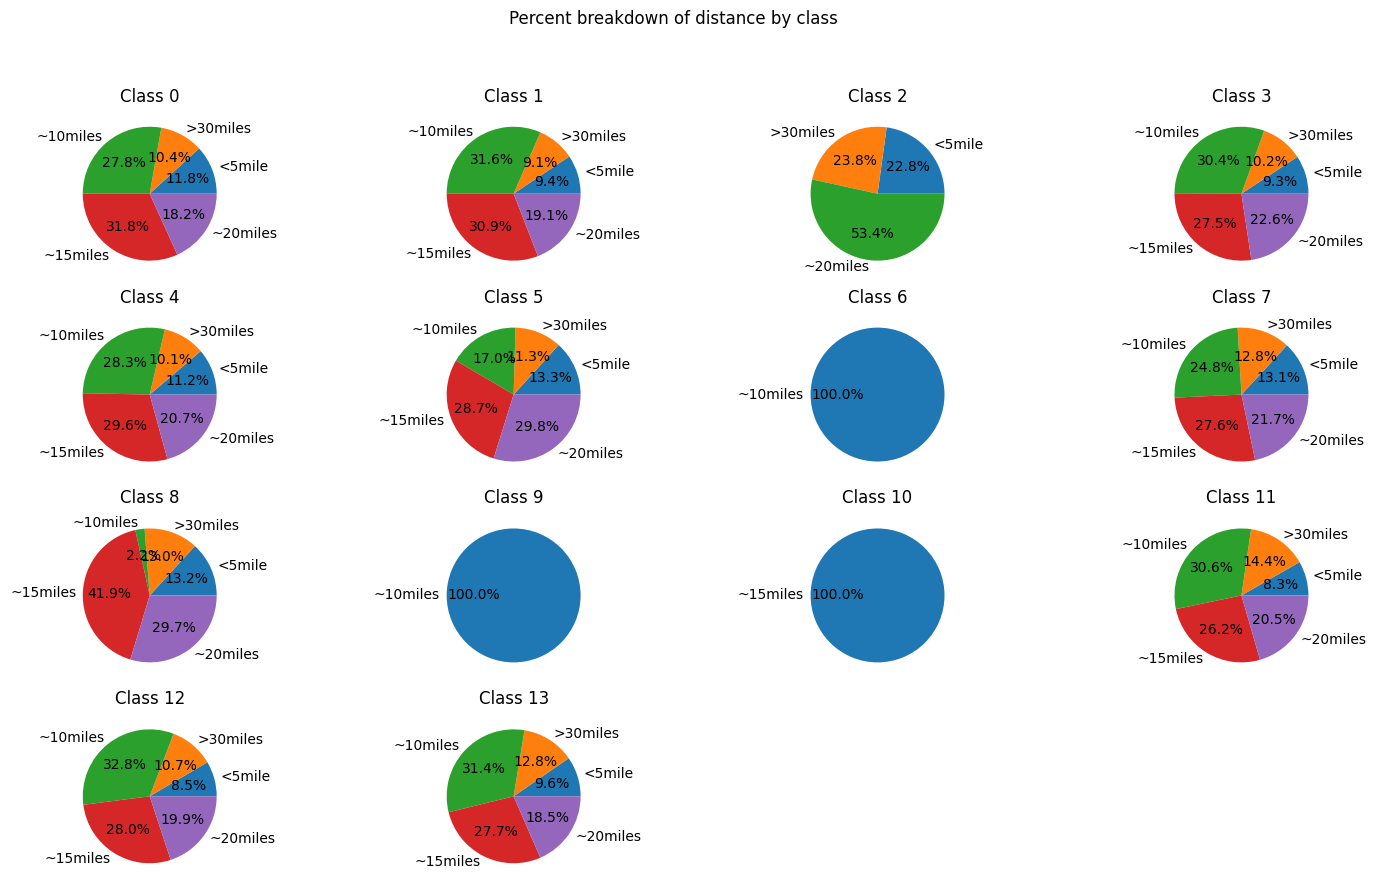

In [ ]:
#Examine percent breakdown of 'Distance' by class

plt.figure(figsize=(18,10))
colors = plt.cm.tab10.colors

for i in range(0, 14):
  row = 0
  if i > 3:
    row = 1
  if i > 7:
    row = 2
  if i > 11:
    row = 3
  column = i%4
  class_distance_total = class_distance[i, :].values.sum()
  class_i = class_distance[i, :].values/class_distance_total
  distance_labels = class_distance[i].index
  ax1 = plt.subplot2grid((4,4), (row, column))
  plt.pie(class_i, labels=distance_labels, autopct='%1.1f%%', colors=colors)
  plt.title(f'Class {i}')


plt.suptitle('Percent breakdown of distance by class')
plt.show()

> Most classes have the same 'Distance' distribution. May be significant but hard to tell.

> Class 2 is majority made up of those with a longer commute to work.

> Class 6, 9, and 10 are 100% of only one 'Distance' value. Could this be part of how the clusters are forming?

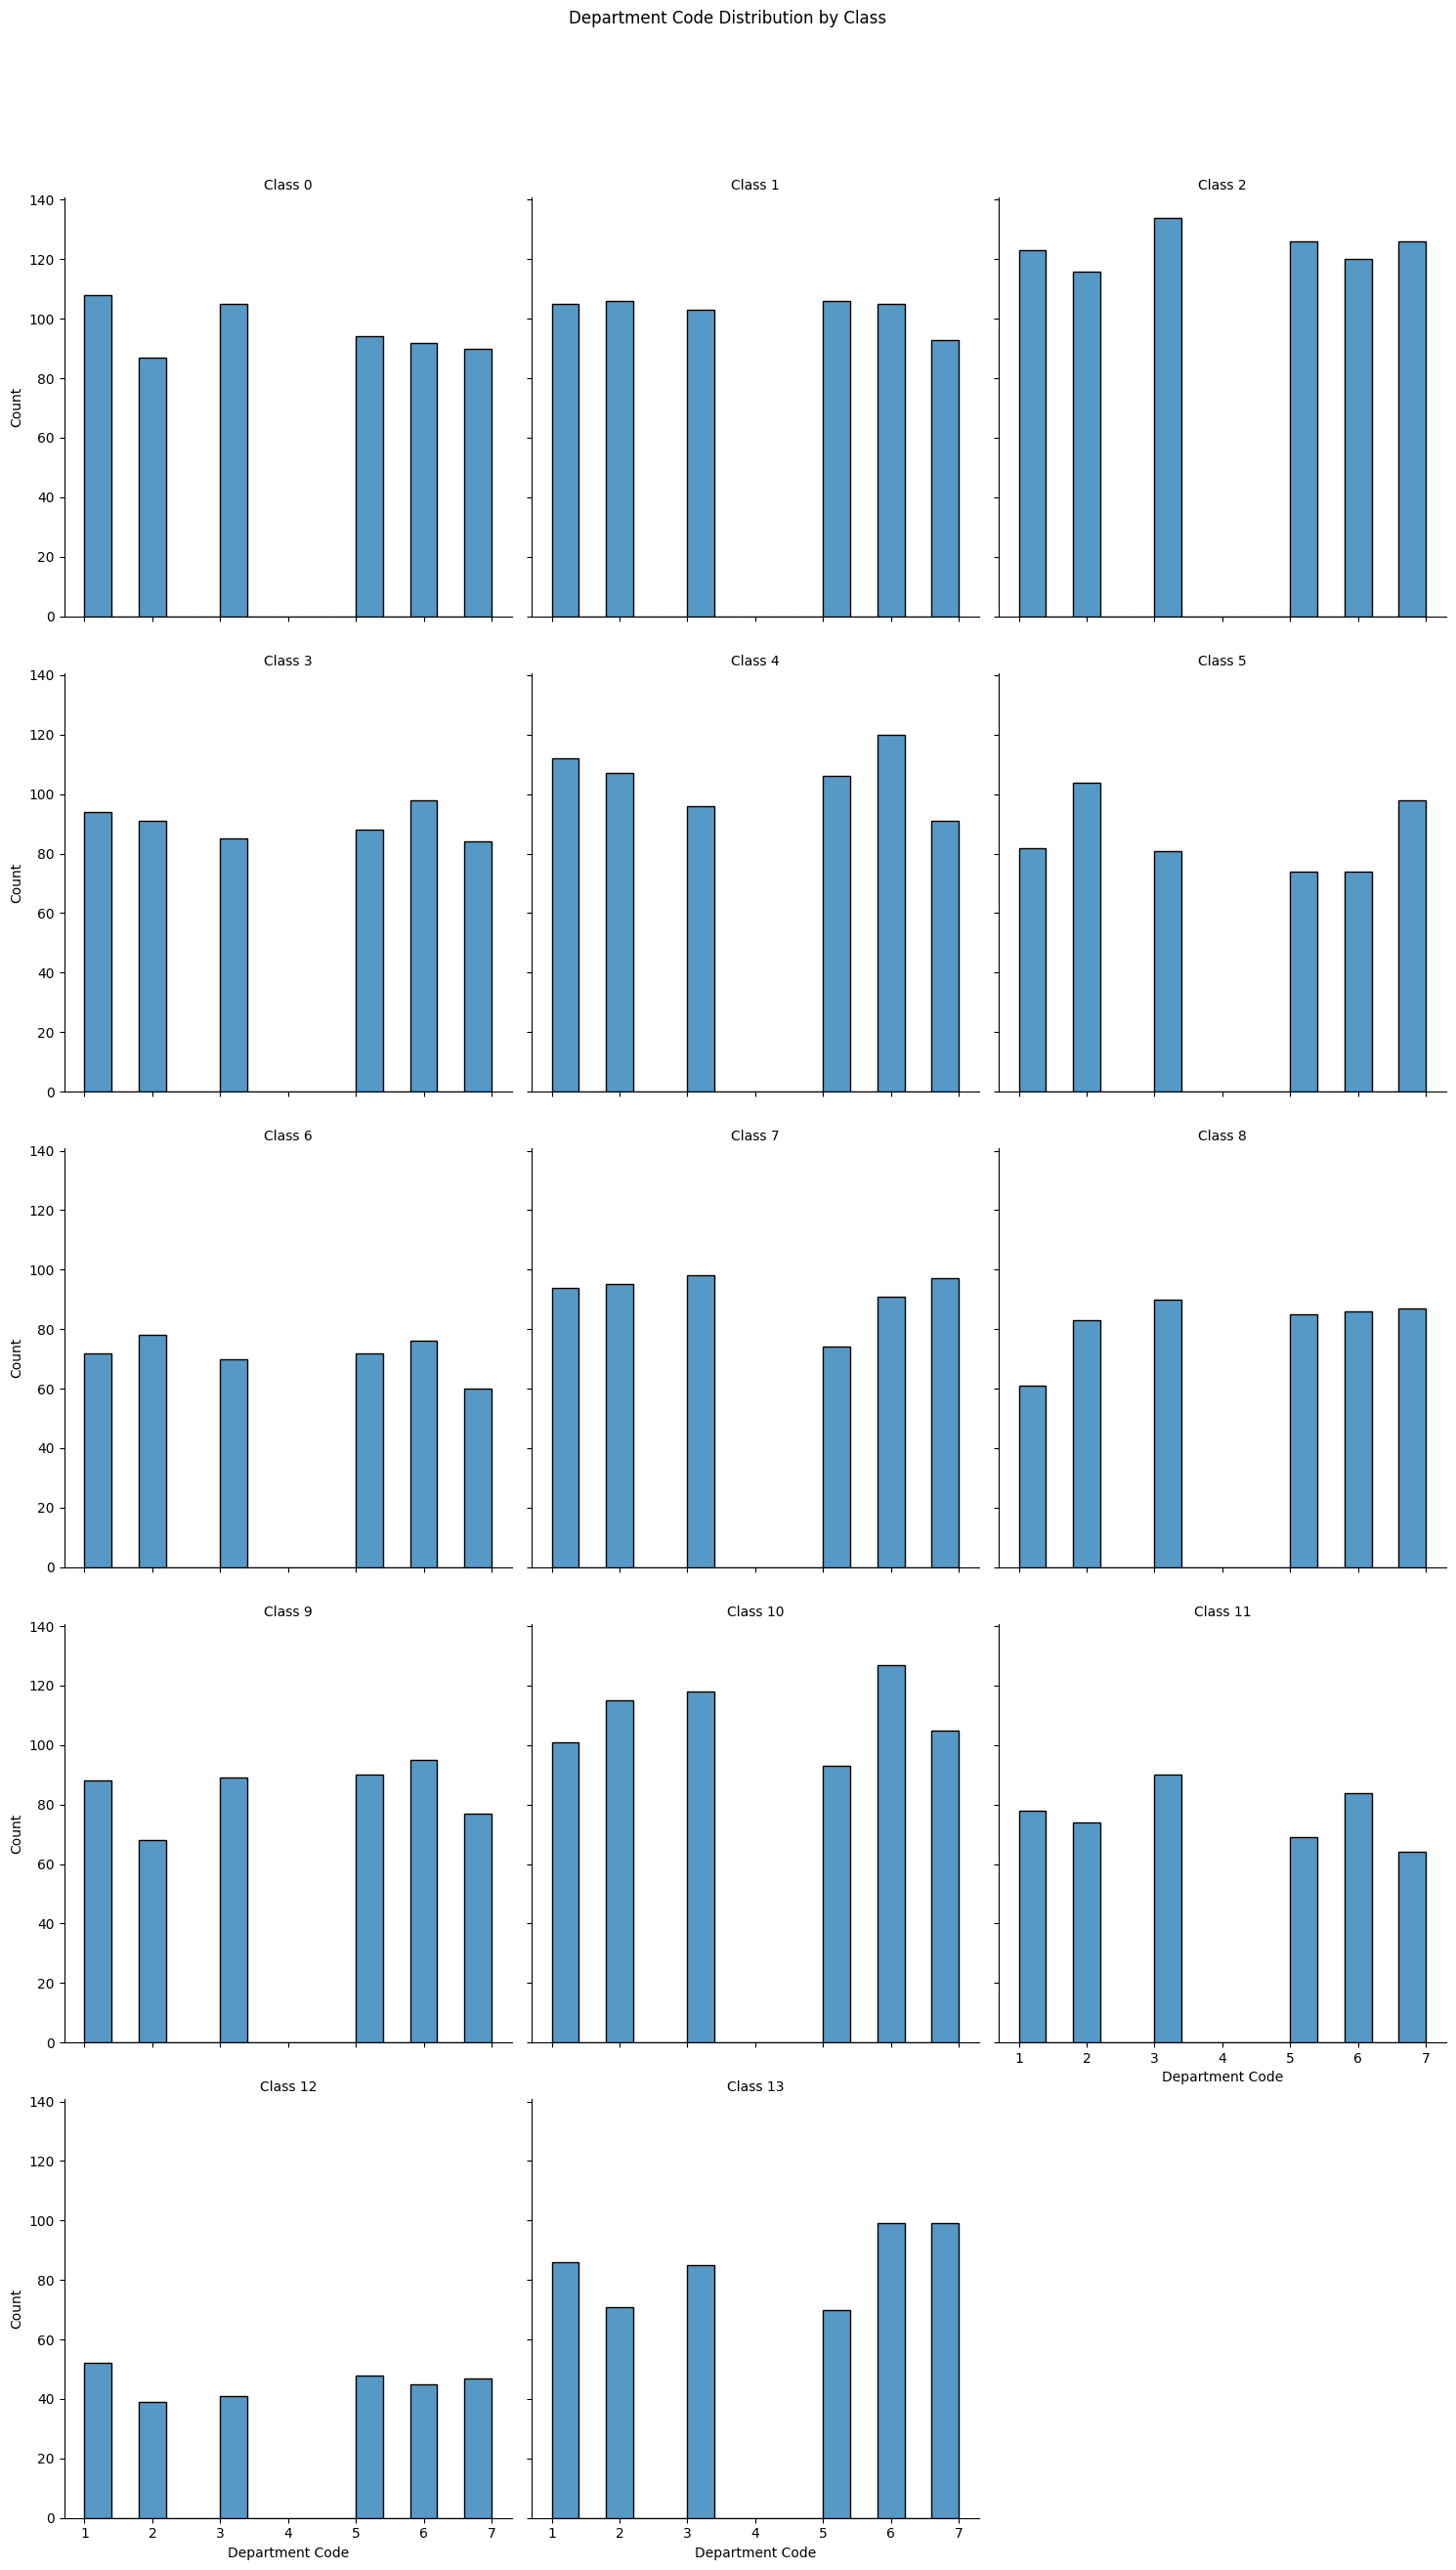

In [ ]:
#Plot distribution of Department Code by assigned cluster class
g = sns.displot(
    data = new_X_train_df, x = 'DepartmentCode', col = 'class', col_wrap = 3
)

g.set_titles(col_template="Class {col_name}")
g.fig.suptitle("Department Code Distribution by Class", y=1.05)

# Set x-labels for all subplots
for ax in g.axes.flatten():
    ax.set_xlabel('Department Code')

plt.tight_layout()
plt.show()

> No discernable difference in Dept Code by class.

<ipython-input-33-41edce1f8843>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y='Salary', data=new_X_train_df, palette='Set3')


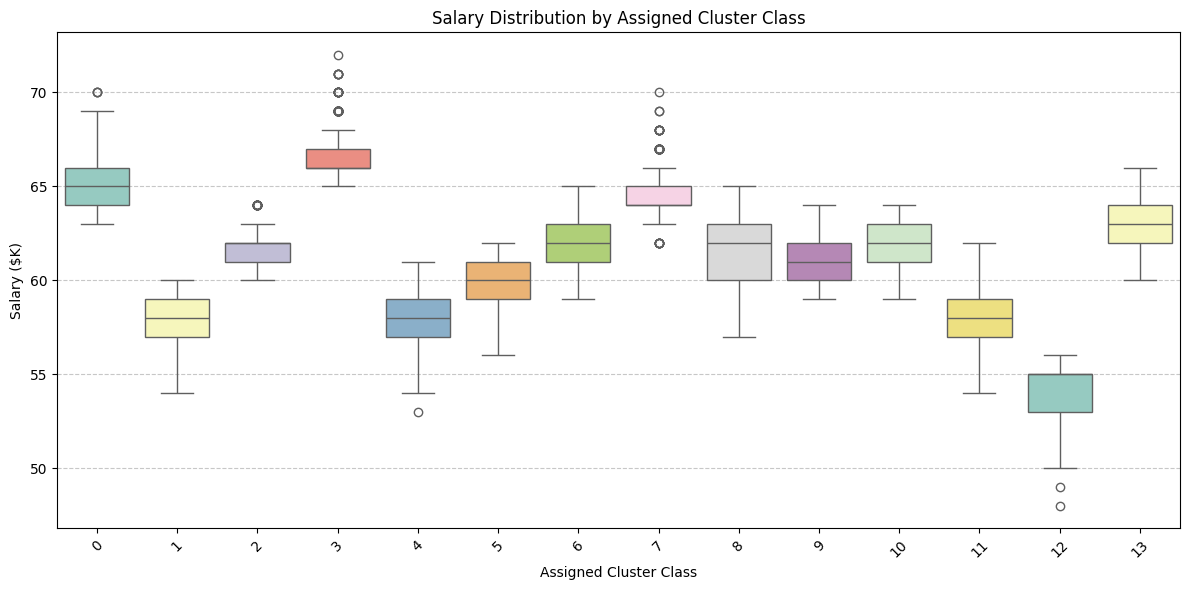

In [ ]:
#Box Plot to show distribution of Salary by Assigned Cluster Class

plt.figure(figsize=(12, 6))
sns.boxplot(x='class', y='Salary', data=new_X_train_df, palette='Set3')
plt.xlabel('Assigned Cluster Class')
plt.ylabel('Salary ($K)')
plt.title('Salary Distribution by Assigned Cluster Class')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

> Class 0 and Class 3 have high salary distributions. Class 3 is very separated from the rest of the classes - similar to the cluster graph. Salary may be a significant factor in the unsupervised classification process.

> The lowest salary distribution / range occurs in class 12.

> The majority of the classes that overlap on the cluster graph are within a similar range on the salary distribution graph as well.

<ipython-input-34-5db3033d9711>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y='YearsWorked', data=new_X_train_df, palette='Set3')


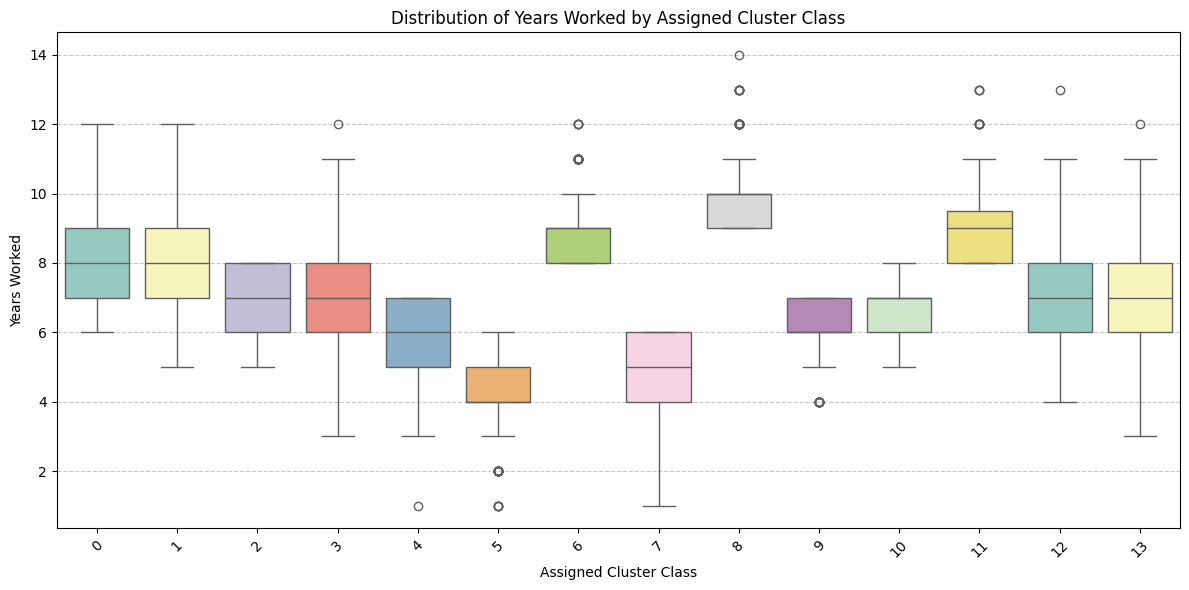

In [ ]:
#Box Plot to show distribution of Years Worked by Assigned Cluster Class

plt.figure(figsize=(12, 6))
sns.boxplot(x='class', y='YearsWorked', data=new_X_train_df, palette='Set3')
plt.xlabel('Assigned Cluster Class')
plt.ylabel('Years Worked')
plt.title('Distribution of Years Worked by Assigned Cluster Class')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

> Not much distinction between classes 0, 1, and 3 - in terms of years worked.

> Class 6 and 8 are showing the highest values of years worked.

> Difficult to discern the distinctions the unsupervised kmeans clustering is making between classes with regards to years worked.

<ipython-input-35-345ed0aaf4c6>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y='SalaryDiff', data=new_X_train_df, palette='Set3')


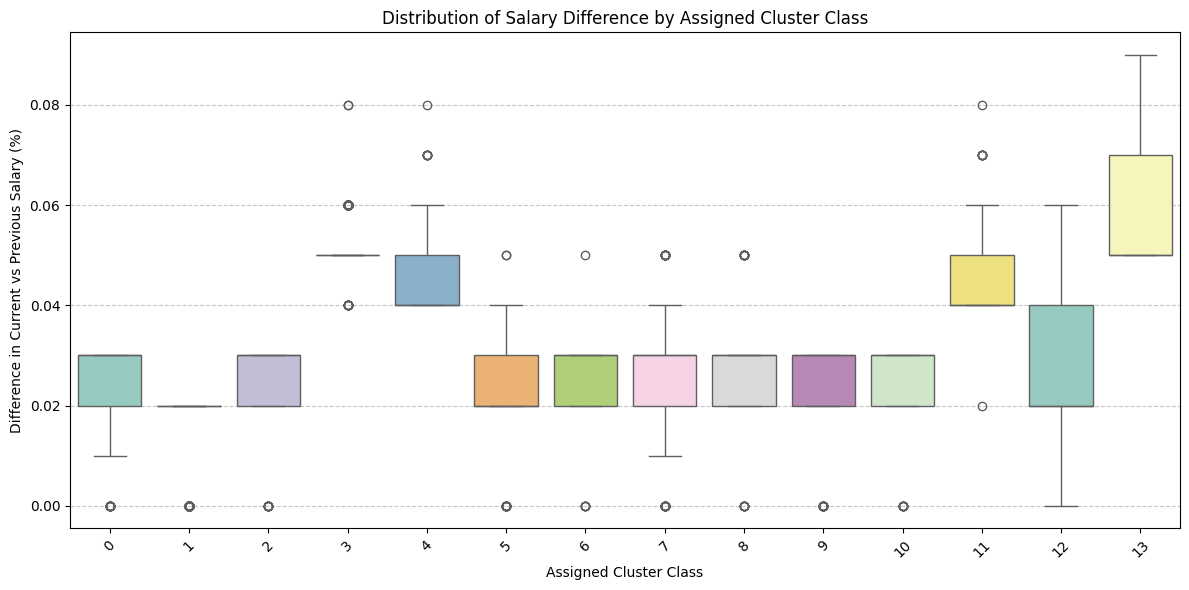

In [ ]:
#Box Plot to show distribution of SalaryDiff by Assigned Cluster Class

plt.figure(figsize=(12, 6))
sns.boxplot(x='class', y='SalaryDiff', data=new_X_train_df, palette='Set3')
plt.xlabel('Assigned Cluster Class')
plt.ylabel('Difference in Current vs Previous Salary (%)')
plt.title('Distribution of Salary Difference by Assigned Cluster Class')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

> Class 1 experiences only a 0% or 2% raise for each individual in the class - *Could this make them more likely to leave?*

> Classes 3, 4, 11, and 13 have the highest % salary increase - *Could this make them more likely to stay?*

> The distribution of salary difference between most classes is the same.

In [ ]:
#Determine # of data points in each cluster
new_X_train_df['class'].value_counts()

class
2     745
10    659
4     632
1     618
0     576
7     549
3     540
5     513
13    510
9     507
8     492
11    459
6     428
12    272
Name: count, dtype: int64

> Some classes contain far fewer data points than others

##Ask the Subject Matter Expert##

Now that we have our class labels, we will gather a sample of employees from each class and bring them to our Subject Matter Expert - John.

John can let us know whether or not the employee records show that they 'Stayed (0)' or 'Left (1)'.

Classes will be assigned the 'Left' label of (0/1) based on the majority result in each class.

In [ ]:
#Gather sample lines from each class to ask the SME about
num_samples = 34
list_1 = []  # List to store samples

def revertSalary(x):
    reverted_x = str(x)
    reverted_x = reverted_x + 'K'
    return reverted_x

for i in range(0, 14):
  cluster = new_X_train_df[new_X_train_df['class'] == i]
  sample_to_ask_SME = cluster.sample(n = num_samples, random_state=42)
  sample_to_ask_SME['PreviousSalary'] = sample_to_ask_SME['PreviousSalary'].apply(revertSalary)
  sample_to_ask_SME['Salary'] = sample_to_ask_SME['Salary'].apply(revertSalary)
  sample_to_ask_SME['Gender'] = sample_to_ask_SME['Gender'].map({'M': 0, 'F': 1})

  list_1.append(sample_to_ask_SME)

  print(f'Class {i}:', len(sample_to_ask_SME))


ask_SME_df = pd.concat(list_1)

Class 0: 34
Class 1: 34
Class 2: 34
Class 3: 34
Class 4: 34
Class 5: 34
Class 6: 34
Class 7: 34
Class 8: 34
Class 9: 34
Class 10: 34
Class 11: 34
Class 12: 34
Class 13: 34


In [ ]:
#Ask SME about employees from each class
left_values = []

for index, row in ask_SME_df.iterrows():

    gender = row['Gender']
    distance = row['Distance']
    years_worked = row['YearsWorked']
    hire_date = row['HireDate']
    prev_salary = row['PreviousSalary']
    current_salary = row['Salary']
    dep_code = row['DepartmentCode']

    # Call the ask function for each row
    result = sme.ask(gender, distance, years_worked, hire_date, prev_salary, current_salary, dep_code)

    left_values.append(result)

#Add 'left' values to
ask_SME_df['Left'] = left_values

# Print the updated DataFrame
print(ask_SME_df)


      Gender  Distance  YearsWorked    HireDate PreviousSalary Salary  \
2781       0  ~15miles            8  2005-01-10            64K    66K   
1428       0  ~10miles           10  2004-06-05            63K    65K   
4258       0  ~10miles            9  2011-07-15            63K    64K   
6438       1  ~10miles            9  2012-03-23            63K    65K   
5165       0  ~15miles            7  2010-10-09            63K    65K   
...      ...       ...          ...         ...            ...    ...   
1234       1  ~10miles            6  2004-02-01            57K    61K   
5550       1  >30miles            7  2012-05-24            59K    63K   
1783       0  ~10miles            3  2012-10-11            60K    64K   
5370       1  ~20miles            8  2002-09-11            61K    64K   
986        1  ~15miles            8  2013-04-17            58K    61K   

      DepartmentCode  SalaryDiff  class  Left  
2781               6        0.03      0     0  
1428               6       

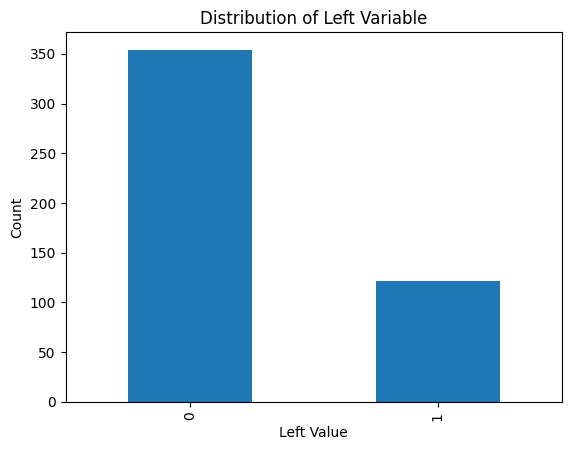

In [ ]:
#look at underlying distribution of 'Left' from our class sample
import matplotlib.pyplot as plt

left_counts = ask_SME_df['Left'].value_counts()

left_counts.plot(kind='bar')
plt.title('Distribution of Left Variable')
plt.xlabel('Left Value')
plt.ylabel('Count')
plt.show()


> Now that we have labeled our data with 'Left' values, we can see the distribtion is highly skewed towards employees staying rather than leaving.

> When modeling, we will want to avoid using accuracy as a metric, given imbalance underlying data.

> **We will opt to use 'F1-score' for scoring metric instead.**

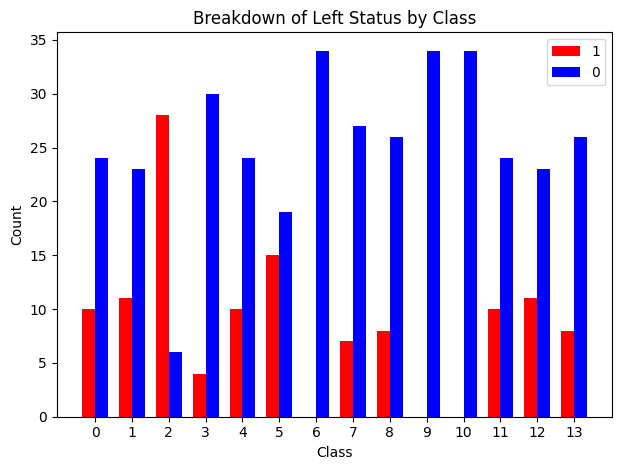

In [ ]:
# Plot distribution of 'Left' status by each class
#ask_SME_df.Left
class_label_count = ask_SME_df.groupby(['class', 'Left']).size().unstack(fill_value=0)

left = class_label_count.loc[:, 1].values
stayed = class_label_count.loc[:, 0].values
classes = list(range(0, 14))

bar_width = 0.35

plt.bar([c - bar_width/2 for c in classes], left, bar_width, color='r', label='1', align='center')
plt.bar([c + bar_width/2 for c in classes], stayed, bar_width, color='b', label='0', align='center')

plt.title('Breakdown of Left Status by Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.xticks(classes, classes)
plt.show()

> A majority of employees across each class sample have **stayed** with the company (Stayed = 0).

> Class 2 shows a much higher distribution of employees who have **left** (Left = 1).

> Based on this distribution we will apply the label of '1' to Class 2 and Class 5 as they show a majority of employees that have left the company.

In [ ]:
#Map individual classes to their corresponding target variable
def assign_left_value(row):
    left_mapping = {0: '0',
                    1: '0',
                    2: '1', #more consistent with a higher % of '1'
                    3: '0',
                    4: '0',
                    5: '1', #fairly consistent high % of '1'
                    6: '0',
                    7: '0',
                    8: '0',
                    9: '0',
                    10: '0',
                    11: '0',
                    12: '0',
                    13: '0'
                    }

    return left_mapping.get(row['class'], None)

new_X_train_df['Left'] = new_X_train_df.apply(assign_left_value, axis=1)
new_X_train_df.head(20)

,Gender,Distance,YearsWorked,HireDate,PreviousSalary,Salary,DepartmentCode,SalaryDiff,class,Left
0,M,~20miles,8,2007-09-05,63,66,3,0.05,3,0
1,M,>30miles,7,2011-10-16,60,63,3,0.05,13,0
2,M,~15miles,7,2011-05-18,59,60,3,0.02,10,0
3,F,<5mile,3,2000-06-30,60,61,2,0.02,5,1
4,F,~10miles,9,2010-04-28,56,57,7,0.02,1,0
5,F,~15miles,10,2008-01-10,60,62,1,0.03,8,0
6,M,~15miles,6,2007-06-10,62,64,2,0.03,10,0
7,M,~15miles,9,2000-02-29,63,64,2,0.02,0,0
8,F,~20miles,7,2007-05-24,59,60,6,0.02,2,1
9,M,~20miles,3,2013-07-16,62,65,7,0.05,7,0


##Model Preparation##

Now we can use the data in different classification models to see how best to predict an employee's tenure or departure.

We need to do some further data prep, as well as apply the original data cleaning methods to the Test Data.

In [ ]:
#Configuring a new y_train to hold the target variable values
model_y_train = new_X_train_df['Left']
model_y_train = model_y_train.map({'0': 0, '1': 1})

#Eliminate class and target variable from X_train
model_X_train = new_X_train_df.drop(['class', 'Left'], axis=1)

In [ ]:
type(model_y_train.unique()[1])

numpy.int64

In [ ]:
#New train-test split
from sklearn.model_selection import train_test_split
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(model_X_train, model_y_train, random_state=1000, test_size=0.2)

In [ ]:
#Apply data cleaning to Test Data
def cleanSalary(x):
    cleaned_x = x.replace('K', '')
    int_x = int(cleaned_x)
    return int_x

X_test['PreviousSalary'] = X_test['PreviousSalary'].apply(cleanSalary)
X_test['Salary'] = X_test['Salary'].apply(cleanSalary)

X_test['SalaryDiff'] = round(((X_test['Salary'] - X_test['PreviousSalary']) / (X_test['PreviousSalary'])),2)

X_test['Gender'] = X_test['Gender'].map({0: 'M', 1: 'F'})

X_test.head(5)

,Gender,Distance,YearsWorked,HireDate,PreviousSalary,Salary,DepartmentCode,SalaryDiff
0,F,<5mile,6,2011-07-19,59,61,6,0.03
1,M,~15miles,2,2004-03-23,58,60,2,0.03
2,M,~20miles,8,2000-09-19,58,60,7,0.03
3,M,>30miles,6,2008-11-05,59,61,6,0.03
4,F,~10miles,6,1999-01-16,58,59,2,0.02


##Modeling##

**Model #1 - Logistic Regression**

In [ ]:
#Logistic Regression Model
from sklearn.linear_model import LogisticRegression

cat_vars = ['Gender', 'Distance', 'DepartmentCode']
num_vars = ['YearsWorked', 'PreviousSalary', 'Salary', 'SalaryDiff'] #'Tenure_CurrentSalary' #'Tenure_SalaryDiff'

cat_pipeline = Pipeline([
    ('impute_missing_cats', SimpleImputer(strategy='most_frequent')),
    ('encoding', OneHotEncoder(drop='first', handle_unknown = 'ignore'))
])

num_pipeline = Pipeline([
    ('impute_missing', SimpleImputer(strategy='median')),
    ('scaling', StandardScaler())
])

processing_pipeline = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_vars),
    ('cat_pipeline', cat_pipeline, cat_vars)
])

logreg_modeling_pipeline = Pipeline([('processing', processing_pipeline),
                                       ('logreg', LogisticRegression())])

In [ ]:
#Find ideal hyperparameters using GridSearchCV
from sklearn.model_selection import GridSearchCV

logreg_param_grid = [
  {
    'logreg__penalty': [None, 'l2'],
    'logreg__class_weight': [None, 'balanced'],
    'logreg__C': [0.1, 1, 10, 100, 1000]
  }
 ]

scoring= 'f1'

logreg_gcv = GridSearchCV(estimator=logreg_modeling_pipeline, param_grid=logreg_param_grid, cv=5, scoring=scoring)
logreg_gcv_results = logreg_gcv.fit(X_train_sub, y_train_sub)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and

In [ ]:
#Identify best parameters
logreg_gcv_results.best_params_

{'logreg__C': 10, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l2'}

In [ ]:
#Use log model with best parameters on training data
logreg_gcv_results.score(X_train_sub, y_train_sub)

0.7118896757361164

In [ ]:
#Use log model with best parameters on test data from train/test split
logreg_gcv_results.score(X_test_sub, y_test_sub)

0.6989720998531571

> Not showing signs of overfitting - training and testing data from train/test split are performing similarly. Test data slightly poorer outcome.

In [ ]:
#Finally, test on ACTUAL TEST DATA
logreg_gcv_results.score(X_test, y_test)

0.5466472303206997

> The test on **ACTUAL** test data shows a significant reduction in performance. Perhaps overfitting is present with the model being too reliant on the makeup of the training data.

> This is not all that surprising, given the overlap of certain classes created in previous steps.

In [ ]:
#Anaylze log model results further with classification report
from sklearn.metrics import classification_report

y_hat = logreg_gcv_results.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83      1847
           1       0.52      0.57      0.55       653

    accuracy                           0.75      2500
   macro avg       0.68      0.69      0.69      2500
weighted avg       0.76      0.75      0.75      2500



> The model is having a harder time predicting instances of '1' due to the imbalance in the data. This is not surprising.

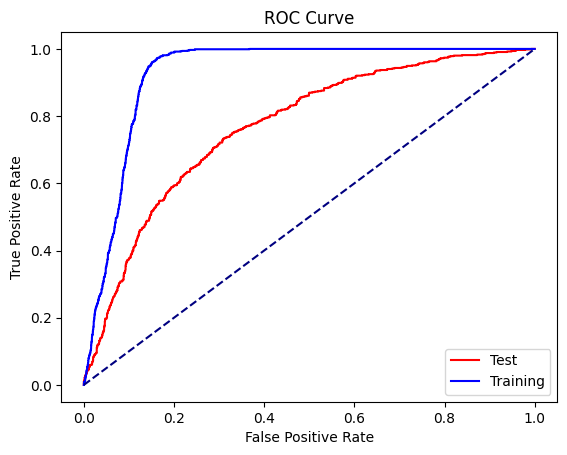

In [ ]:
#ROC curve to look at model performance / possible overfit or underfit - logistic regression model
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def generate_probs(X, model):
    return model.predict_proba(X)[:, 1]

def generate_roc(y, probs):
    fpr, tpr, _ = roc_curve(y, probs)
    return fpr, tpr

fpr_test, tpr_test = generate_roc(y_test, generate_probs(X_test, logreg_gcv_results))
fpr_train, tpr_train = generate_roc(y_train_sub, generate_probs(X_train_sub, logreg_gcv_results))

plt.plot(fpr_test, tpr_test,'-r')
plt.plot(fpr_train, tpr_train,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Test','Training'])
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

Visualization of the underperformance on the Test data.

In [ ]:
#print ROC scores
print("training roc score", roc_auc_score(y_train_sub, generate_probs(X_train_sub, logreg_gcv_results)))
print("test roc score", roc_auc_score(y_test, generate_probs(X_test, logreg_gcv_results)))

training roc score 0.9273722877238502
test roc score 0.768728479028531


**Model #2: Decision Tree Classifier**

In [ ]:
#Create decision tree modeling pipeline
from sklearn.tree import DecisionTreeClassifier

dt_modeling_pipeline = Pipeline([
    ('processing', processing_pipeline),
    ('dt', DecisionTreeClassifier())
])
dt_modeling_pipeline

Pipeline(steps=[('processing',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['YearsWorked',
                                                   'PreviousSalary', 'Salary',
                                                   'SalaryDiff']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoding',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Gender', 'Distance',
                                                   'DepartmentCode'])])),
                ('dt', DecisionTreeClassifier())])

In [ ]:
#Find ideal hyperparameters
dt_param_grid = [
    {
        'dt__max_depth': [6, 7, 8],
        'dt__min_samples_leaf': [1, 5, 10]
    }
]

scoring = 'f1'

dt_gc = GridSearchCV(estimator=dt_modeling_pipeline, param_grid=dt_param_grid, cv=5, scoring=scoring)
dt_gcv_results = dt_gc.fit(X_train_sub, y_train_sub)

In [ ]:
#Find best params
dt_gcv_results.best_params_

{'dt__max_depth': 8, 'dt__min_samples_leaf': 1}

In [ ]:
#Use DT with best params on training data
dt_gcv_results.score(X_train_sub, y_train_sub)

0.9465648854961831

In [ ]:
#Use DT with best params on test data from train/test split
dt_gcv_results.score(X_test_sub, y_test_sub)

0.9404990403071017

In [ ]:
#Use DT with best params on ACTUAL Test Data
dt_gcv_results.score(X_test, y_test)

0.41348713398402837

> Originally, we see the DT model performing well on the training data.

> However, when given the **ACTUAL** Test Data, it's score drops significantly from 94% to 41%.

> Model could be overfitting due to overdependence on the makeup of the training data.

In [ ]:
#Anaylze dt model results further with classification report
y_hat = dt_gcv_results.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1847
           1       0.49      0.36      0.41       653

    accuracy                           0.74      2500
   macro avg       0.64      0.61      0.62      2500
weighted avg       0.71      0.74      0.72      2500



Let's try the addition of 'BaggingClassifier' to Decision Tree Model

In [ ]:
from sklearn.ensemble import BaggingClassifier

dt = DecisionTreeClassifier() #add in best parameters from above?
bclf = BaggingClassifier(estimator=dt)

bclf_pipe = Pipeline([('processing', processing_pipeline),
                      ('baggingclassifier', bclf)])

params = {
    'baggingclassifier__n_estimators': [10, 15, 20],
    #'estimator__max_depth':[1, 2, 4, 6],
    'baggingclassifier__max_samples':[0.1, 0.2, 0.3, 0.4, 0.5]
}

blrcv = GridSearchCV(bclf_pipe, param_grid=params, cv=10, scoring='f1')
blrcv = blrcv.fit(X_train_sub, y_train_sub)

In [ ]:
#Use bagging model with best params on training data
blrcv.score(X_train_sub, y_train_sub)

0.9965260545905706

In [ ]:
#Use bagging model with best params on test data from train/test split
blrcv.score(X_test_sub, y_test_sub)

0.988

In [ ]:
#Use bagging model with best params on actual test data
blrcv.score(X_test, y_test)

0.42962962962962964

> Bagging was able to boost all of the scores slightly. Not a significant enough increase to warrant the extra computing power.

> Again we see that the model is not able to perform as well on the actual test data.

In [ ]:
#Anaylze dt model (w/ bagging) results further with classification report
y_hat = blrcv.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84      1847
           1       0.54      0.36      0.43       653

    accuracy                           0.75      2500
   macro avg       0.67      0.62      0.64      2500
weighted avg       0.73      0.75      0.73      2500



Test of Gradient Boosting Classifier

In [ ]:
#test gradient boosting classifier
from sklearn.ensemble import GradientBoostingClassifier

gradient_boost_model = Pipeline([('processing', processing_pipeline),
             ('gb', GradientBoostingClassifier())])

params = {'gb__max_depth': [1, 2, 3],
          'gb__n_estimators': [50, 100, 200]
         }

gb_gscv = GridSearchCV(gradient_boost_model, param_grid = params, cv=5, scoring='f1')

#test on training data
gb_gscv = gb_gscv.fit(X_train_sub, y_train_sub)

print(f'Validation score: {gb_gscv.best_score_:.2%}')

#test on testing data from train/test split
gb_pred = gb_gscv.predict(X_test_sub)

print(f'Test score: {gb_gscv.score(X_test_sub, y_test_sub):.2%}')

Validation score: 98.61%
Test score: 98.80%


In [ ]:
#test on actual test data
gb_gscv.score(X_test, y_test)

0.43278084714548803

> Once again, a slight increase in score using an ensemble method - but not great overall.

> More initial data may be needed to help the model distinguish between classes in the clustering steps so that proper 'Left' labels are applied to the training data that the model uses for learning how to make predictions.

In [ ]:
#Anaylze gradient boosting model results further with classification report
y_hat = gb_gscv.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84      1847
           1       0.54      0.36      0.43       653

    accuracy                           0.75      2500
   macro avg       0.67      0.63      0.64      2500
weighted avg       0.73      0.75      0.74      2500



##Conclusions:##

> Our best model method for predicting whether an employee left or stayed with the company, at this time, is Logistic Regression with a score of ~55%.

> This is not much better than a random person's 50/50 guess on if someone will leave or not, so there is **a lot of room for improvement**.



##Next Steps:#

> We would like to visualize the data from different angles to see if theres a way to tease out the characteristics that contribute to an employee leaving the company.

> We could collect more initial employee data that could be used to help the clustering model separate classes more effectively.

> We would like to do further investigation into individual classes - for example; asking the SME about a larger amount of employees in a single class to determine the true 'Left' / 'Stayed' Ratio.